# 文本分类任务
##  1.导入必要的库

In [2]:
import os
import numpy as np
import jieba
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tabulate import tabulate

# 设置支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False   # 解决负号显示问题

## 2.加载数据并使用jieba分词
通过多线程加速分词和停用词过滤，减少运行时间。

In [3]:
def load_stopwords(stopwords_path):
    """加载停用词"""
    with open(stopwords_path, 'r', encoding='utf-8') as f:
        stopwords = set(line.strip() for line in f)
    return stopwords

def segment_text(text, stopwords):
    """使用 jieba 分词，并去除停用词"""
    words = jieba.lcut(text, HMM=False)
    filtered_words = [word for word in words if word not in stopwords and word.strip()]
    return " ".join(filtered_words)

def load_data_in_batches(file_path, stopwords, batch_size=1000, max_workers=4):
    """
    分批加载数据并进行分词，避免一次性加载所有数据。
    使用多线程加速分词过程，并去除停用词。
    """
    texts = []
    labels = []
    label_map = {"体育": 0, "财经": 1, "房产": 2, "家居": 3, "教育": 4, "科技": 5}
    
    with open(file_path, 'r', encoding='utf-8') as f:
        batch_texts, batch_labels = [], []
        
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) == 2:
                label, text = parts
                batch_texts.append(text)
                batch_labels.append(label_map[label])
            
            # 每次处理一个批次的数据
            if len(batch_texts) >= batch_size:
                # 多线程分词
                with ThreadPoolExecutor(max_workers=max_workers) as executor:
                    segmented_texts = list(executor.map(lambda x: segment_text(x, stopwords), batch_texts))
                
                texts.extend(segmented_texts)
                labels.extend(batch_labels)
                
                # 清空当前批次
                batch_texts, batch_labels = [], []
        
        # 处理剩余数据
        if batch_texts:
            with ThreadPoolExecutor(max_workers=max_workers) as executor:
                segmented_texts = list(executor.map(lambda x: segment_text(x, stopwords), batch_texts))
            
            texts.extend(segmented_texts)
            labels.extend(batch_labels)
    
    return texts, labels

# 数据文件路径
file_path = r"C:\Users\安然淡漠如欣\Desktop\中文文本分类\filtered_cnews.train.txt"
stopwords_path = r"C:\Users\安然淡漠如欣\Desktop\中文文本分类\stopwords.txt"

# 加载停用词
stopwords = load_stopwords(stopwords_path)

# 加载数据
texts, labels = load_data_in_batches(file_path, stopwords)

print(f"Loaded {len(texts)} texts and {len(labels)} labels.")
print("Sample segmented text:", texts[0])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\安然淡~1\AppData\Local\Temp\jieba.cache
Loading model cost 2.341 seconds.
Prefix dict has been built successfully.


Loaded 30000 texts and 30000 labels.
Sample segmented text: 马 晓 旭 意外 受伤 国奥 警惕 无奈 大雨 格外 青睐 殷家 军 记者 傅 亚 雨 沈阳 报道 来到 沈阳 国奥队 依然 没有 摆脱 雨水 困扰 7 月 31 日 下午 6 点 国奥队 日常 训练 再度 受到 大雨 干扰 无奈 之下 队员 只 慢跑 25 分钟 草草收场 31 日 上午 10 点 国奥队 奥体中心 外场 训练 天 阴沉沉 气象预报 显示 当天 下午 沈阳 大雨 幸好 队伍 上午 训练 没有 受到 干扰 下午 6 点 球队 抵达 训练场 时 大雨 已经 下 几个 小时 丝毫 没有 停下来 意思 抱 试一试 态度 球队 当天 下午 例行 训练 25 分钟 过去 天气 没有 转 好 迹象 保护 球员 国奥队 决定 中止 当天 训练 全队 立即 返回 酒店 雨 中 训练 足球队 来说 不是 稀罕 事 奥运会 即将 之前 全队 变得 娇贵 沈阳 最后 一周 训练 国奥队 保证 现有 球员 不再 出现意外 伤病 情况 影响 正式 比赛 阶段 控制 训练 受伤 控制 感冒 疾病 出现 队伍 放在 相当 重要 位置 抵达 沈阳 之后 中 后卫 冯 萧 霆 没有 训练 冯 萧 霆 7 月 27 日 长春 患上 感冒 没有 参加 29 日 塞尔维亚 热身赛 队伍 介绍 说 冯 萧 霆 没有 出现 发烧 症状 安全 见 两天 静养 休息 感冒 彻底 好 之后 再 恢复 训练 冯 萧 霆 例子 国奥队 雨 中 训练 显得 特别 谨慎 主要 担心 球员 受凉 引发 感冒 造成 非战斗 减员 女足 队员 马 晓 旭 热身赛 中 受伤 导致 无缘 奥运 前科 沈阳 国奥队 现在 格外 警惕 训练 中 不断 嘱咐 队员 注意 动作 不能 再 出 事情 一位 工作人员 表示 长春 沈阳 雨水 一路 伴随 国奥队 邪 走 雨 下 长春 几次 训练 都 大雨 搅和 没想到 沈阳 碰到 这种 事情 一位 国奥 球员 雨水 青睐 不解


## 3.划分训练集、验证集和测试集
使用 train_test_split 进行两次划分：  
第一次划分：训练集占 80%，临时集占 20%  
第二次划分：将临时集平分为验证集和测试集

In [4]:
def split_data(texts, labels):
    # 第一次划分：训练集和临时集
    train_texts, temp_texts, train_labels, temp_labels = train_test_split(
        texts, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    # 第二次划分：验证集和测试集
    val_texts, test_texts, val_labels, test_labels = train_test_split(
        temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
    )
    
    return train_texts, val_texts, test_texts, train_labels, val_labels, test_labels

train_texts, val_texts, test_texts, train_labels, val_labels, test_labels = split_data(texts, labels)

print(f"Train set: {len(train_texts)} samples")
print(f"Validation set: {len(val_texts)} samples")
print(f"Test set: {len(test_texts)} samples")

Train set: 24000 samples
Validation set: 3000 samples
Test set: 3000 samples


## 4.特征提取与降维
使用 TfidfVectorizer 提取文本特征；选择使用 TruncatedSVD 进行降维  
**PCA** 和 **TruncatedSVD** 的对比：

| **对比维度** | **PCA**                                   | **TruncatedSVD**                           |
|--------------|------------------------------------------|--------------------------------------------|
| **原理**     | 特征值分解协方差矩阵，找主成分。          | 奇异值分解稀疏矩阵，无需协方差矩阵。        |
| **适用场景** | 稠密数据（如图像、音频）。                | 稀疏数据（如文本分类中的 TF-IDF）。         |
| **预处理**   | 需中心化数据，稀疏数据需转化为稠密矩阵。   | 无需中心化，直接处理稀疏矩阵。              |
| **效率**     | 计算复杂度高，内存消耗大。                | 计算效率高，内存消耗小。                    |

In [5]:
def extract_features(train_texts, val_texts, test_texts):
    vectorizer = TfidfVectorizer(max_features=5000)  # 限制特征数量为 5000
    
    # 训练集拟合并转换
    X_train = vectorizer.fit_transform(train_texts)
    
    # 验证集和测试集只进行转换
    X_val = vectorizer.transform(val_texts)
    X_test = vectorizer.transform(test_texts)
    
    return X_train, X_val, X_test, vectorizer

def apply_truncated_svd(X_train, X_val, X_test, n_components=100):
    """使用 TruncatedSVD 进行降维"""
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    X_train_svd = svd.fit_transform(X_train)
    X_val_svd = svd.transform(X_val)
    X_test_svd = svd.transform(X_test)
    return X_train_svd, X_val_svd, X_test_svd

X_train, X_val, X_test, vectorizer = extract_features(train_texts, val_texts, test_texts)
X_train_svd, X_val_svd, X_test_svd = apply_truncated_svd(X_train, X_val, X_test)

print(f"Feature matrix shape (train): {X_train.shape}")
print(f"SVD-reduced feature matrix shape (train): {X_train_svd.shape}")

Feature matrix shape (train): (24000, 5000)
SVD-reduced feature matrix shape (train): (24000, 100)


## 5.模型训练与评估
1）分别使用朴素贝叶斯、KNN 和 GBDT 完成训练和评估。  
2）朴素贝叶斯 ：直接使用原始 TF-IDF 特征矩阵（未降维）；朴素贝叶斯对高维稀疏数据具有天然的适应性，因此不需要降维。  
3）KNN 和 GBDT ：使用降维后的数据（TruncatedSVD）；高维稀疏数据会导致 KNN 和 GBDT 的性能下降，因此需要通过降维优化特征空间。  



=== 朴素贝叶斯 验证集分类报告 ===
+--------------+-------------+----------+------------+-----------+
| 类别         |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
| 体育         |      0.9901 |    0.998 |     0.994  |   500     |
+--------------+-------------+----------+------------+-----------+
| 财经         |      0.9328 |    0.916 |     0.9243 |   500     |
+--------------+-------------+----------+------------+-----------+
| 房产         |      0.9287 |    0.938 |     0.9333 |   500     |
+--------------+-------------+----------+------------+-----------+
| 家居         |      0.945  |    0.928 |     0.9364 |   500     |
+--------------+-------------+----------+------------+-----------+
| 教育         |      0.931  |    0.918 |     0.9245 |   500     |
+--------------+-------------+----------+------------+-----------+
| 科技         |      0.9244 |    0.954 |     0.939  |   500     |
+--------------+-------------+----------+------------

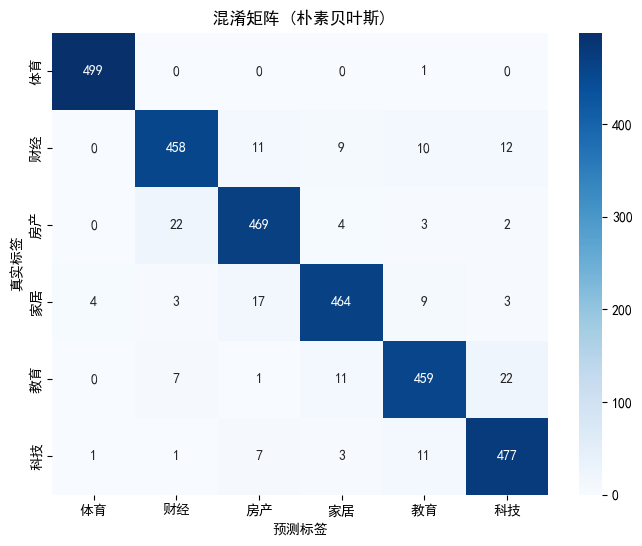


=== 朴素贝叶斯 测试集分类报告 ===
+--------------+-------------+----------+------------+-----------+
| 类别         |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
| 体育         |      0.992  |    0.992 |     0.992  |   500     |
+--------------+-------------+----------+------------+-----------+
| 财经         |      0.9473 |    0.934 |     0.9406 |   500     |
+--------------+-------------+----------+------------+-----------+
| 房产         |      0.9215 |    0.916 |     0.9188 |   500     |
+--------------+-------------+----------+------------+-----------+
| 家居         |      0.9551 |    0.936 |     0.9455 |   500     |
+--------------+-------------+----------+------------+-----------+
| 教育         |      0.9381 |    0.94  |     0.9391 |   500     |
+--------------+-------------+----------+------------+-----------+
| 科技         |      0.9229 |    0.958 |     0.9401 |   500     |
+--------------+-------------+----------+------------

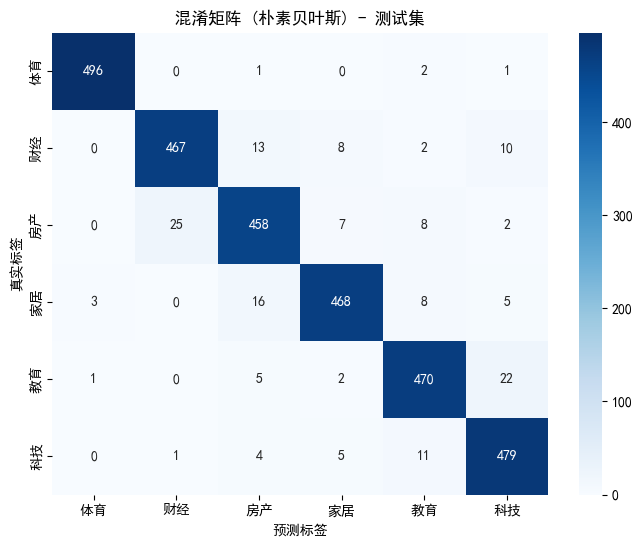


=== KNN 验证集分类报告 ===
+--------------+-------------+----------+------------+-----------+
| 类别         |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
| 体育         |      0.9843 |   1      |     0.9921 |  500      |
+--------------+-------------+----------+------------+-----------+
| 财经         |      0.9306 |   0.938  |     0.9343 |  500      |
+--------------+-------------+----------+------------+-----------+
| 房产         |      0.9366 |   0.946  |     0.9413 |  500      |
+--------------+-------------+----------+------------+-----------+
| 家居         |      0.9562 |   0.918  |     0.9367 |  500      |
+--------------+-------------+----------+------------+-----------+
| 教育         |      0.9453 |   0.934  |     0.9396 |  500      |
+--------------+-------------+----------+------------+-----------+
| 科技         |      0.9273 |   0.944  |     0.9356 |  500      |
+--------------+-------------+----------+------------+-

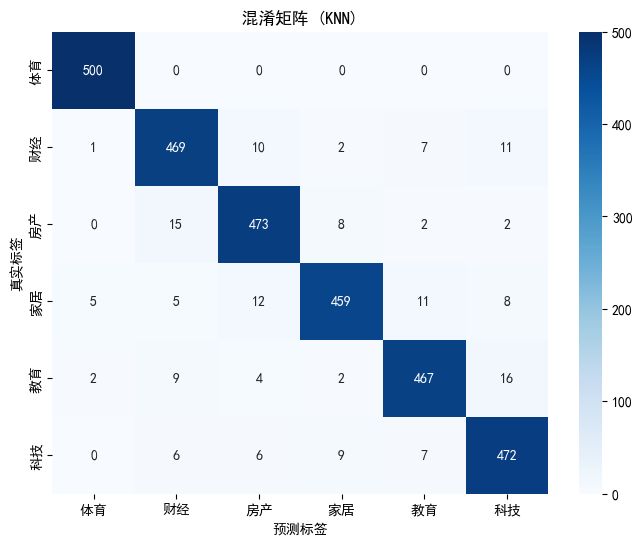


=== KNN 测试集分类报告 ===
+--------------+-------------+----------+------------+-----------+
| 类别         |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
| 体育         |      0.9881 |    0.996 |     0.992  |   500     |
+--------------+-------------+----------+------------+-----------+
| 财经         |      0.9408 |    0.954 |     0.9474 |   500     |
+--------------+-------------+----------+------------+-----------+
| 房产         |      0.9376 |    0.932 |     0.9348 |   500     |
+--------------+-------------+----------+------------+-----------+
| 家居         |      0.9669 |    0.936 |     0.9512 |   500     |
+--------------+-------------+----------+------------+-----------+
| 教育         |      0.9313 |    0.922 |     0.9266 |   500     |
+--------------+-------------+----------+------------+-----------+
| 科技         |      0.9298 |    0.954 |     0.9418 |   500     |
+--------------+-------------+----------+------------+-

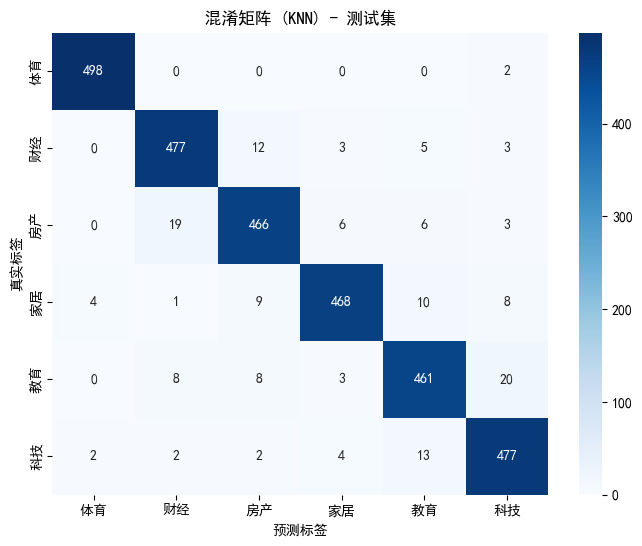


=== GBDT 验证集分类报告 ===
+--------------+-------------+----------+------------+-----------+
| 类别         |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
| 体育         |      0.998  |    0.996 |     0.997  |   500     |
+--------------+-------------+----------+------------+-----------+
| 财经         |      0.9435 |    0.936 |     0.9398 |   500     |
+--------------+-------------+----------+------------+-----------+
| 房产         |      0.9287 |    0.938 |     0.9333 |   500     |
+--------------+-------------+----------+------------+-----------+
| 家居         |      0.9478 |    0.944 |     0.9459 |   500     |
+--------------+-------------+----------+------------+-----------+
| 教育         |      0.9354 |    0.926 |     0.9307 |   500     |
+--------------+-------------+----------+------------+-----------+
| 科技         |      0.929  |    0.942 |     0.9355 |   500     |
+--------------+-------------+----------+------------+

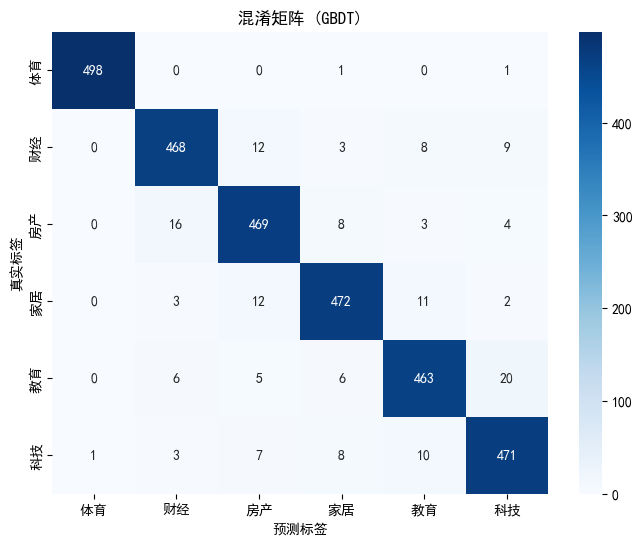


=== GBDT 测试集分类报告 ===
+--------------+-------------+----------+------------+-----------+
| 类别         |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
| 体育         |      0.996  |   0.994  |     0.995  |  500      |
+--------------+-------------+----------+------------+-----------+
| 财经         |      0.954  |   0.954  |     0.954  |  500      |
+--------------+-------------+----------+------------+-----------+
| 房产         |      0.9511 |   0.934  |     0.9425 |  500      |
+--------------+-------------+----------+------------+-----------+
| 家居         |      0.9679 |   0.964  |     0.9659 |  500      |
+--------------+-------------+----------+------------+-----------+
| 教育         |      0.931  |   0.944  |     0.9374 |  500      |
+--------------+-------------+----------+------------+-----------+
| 科技         |      0.9505 |   0.96   |     0.9552 |  500      |
+--------------+-------------+----------+------------+

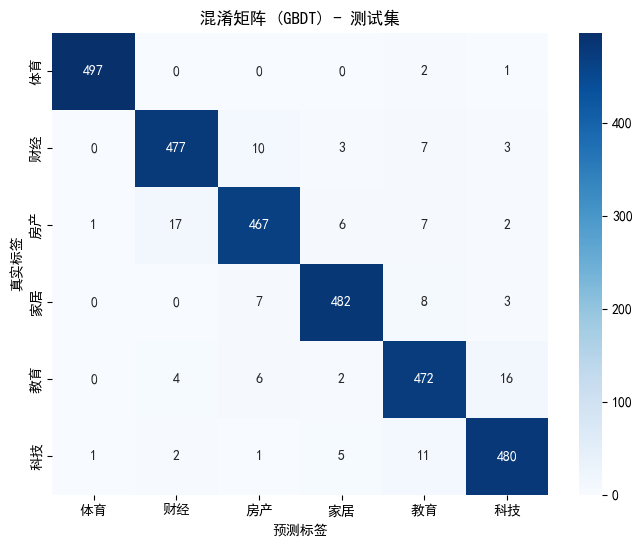

In [7]:
def evaluate_model(model, X_val, y_val, model_name="Model"):
    y_pred = model.predict(X_val)
    
    # 获取分类报告
    report_dict = classification_report(y_val, y_pred, target_names=["体育", "财经", "房产", "家居", "教育", "科技"], output_dict=True)
    report_df = pd.DataFrame(report_dict).T.round(4)
    report_df.index.name = "类别"
    
    # 打印带框线的表格
    print(f"\n=== {model_name} 验证集分类报告 ===")
    print(tabulate(report_df, headers="keys", tablefmt="grid"))
    
    # 输出混淆矩阵热力图
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["体育", "财经", "房产", "家居", "教育", "科技"], 
                yticklabels=["体育", "财经", "房产", "家居", "教育", "科技"])
    plt.xlabel("预测标签")
    plt.ylabel("真实标签")
    plt.title(f"混淆矩阵 ({model_name})")
    plt.show()
    
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_val, y_pred),
        "Macro Precision": report_dict['macro avg']['precision'],
        "Macro Recall": report_dict['macro avg']['recall'],
        "Macro F1-Score": report_dict['macro avg']['f1-score'],
        "Weighted Precision": report_dict['weighted avg']['precision'],
        "Weighted Recall": report_dict['weighted avg']['recall'],
        "Weighted F1-Score": report_dict['weighted avg']['f1-score']
    }

def evaluate_on_test_set(model, X_test, y_test, model_name="Model"):
    """评估模型在测试集上的性能"""
    y_pred = model.predict(X_test)
    
    # 获取分类报告
    report_dict = classification_report(y_test, y_pred, target_names=["体育", "财经", "房产", "家居", "教育", "科技"], output_dict=True)
    report_df = pd.DataFrame(report_dict).T.round(4)
    report_df.index.name = "类别"
    
    # 打印带框线的表格
    print(f"\n=== {model_name} 测试集分类报告 ===")
    print(tabulate(report_df, headers="keys", tablefmt="grid"))
    
    # 输出混淆矩阵热力图
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["体育", "财经", "房产", "家居", "教育", "科技"], 
                yticklabels=["体育", "财经", "房产", "家居", "教育", "科技"])
    plt.xlabel("预测标签")
    plt.ylabel("真实标签")
    plt.title(f"混淆矩阵 ({model_name}) - 测试集")
    plt.show()
    
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Macro Precision": report_dict['macro avg']['precision'],
        "Macro Recall": report_dict['macro avg']['recall'],
        "Macro F1-Score": report_dict['macro avg']['f1-score'],
        "Weighted Precision": report_dict['weighted avg']['precision'],
        "Weighted Recall": report_dict['weighted avg']['recall'],
        "Weighted F1-Score": report_dict['weighted avg']['f1-score']
    }

# 训练朴素贝叶斯模型
nb_model = MultinomialNB()
nb_model.fit(X_train, train_labels)
nb_val_results = evaluate_model(nb_model, X_val, val_labels, model_name="朴素贝叶斯")
nb_test_results = evaluate_on_test_set(nb_model, X_test, test_labels, model_name="朴素贝叶斯")

# 训练 KNN 模型（使用余弦相似度）
knn_model = KNeighborsClassifier(n_neighbors=5, metric='cosine', n_jobs=-1)
knn_model.fit(X_train_svd, train_labels)
knn_val_results = evaluate_model(knn_model, X_val_svd, val_labels, model_name="KNN")
knn_test_results = evaluate_on_test_set(knn_model, X_test_svd, test_labels, model_name="KNN")

# 训练 GBDT 模型
gbdt_model = GradientBoostingClassifier(n_estimators=50, max_depth=5, random_state=42)
gbdt_model.fit(X_train_svd, train_labels)
gbdt_val_results = evaluate_model(gbdt_model, X_val_svd, val_labels, model_name="GBDT")
gbdt_test_results = evaluate_on_test_set(gbdt_model, X_test_svd, test_labels, model_name="GBDT")

## 6.汇总结果

In [8]:
# 汇总验证集结果
val_results_df = pd.DataFrame([nb_val_results, knn_val_results, gbdt_val_results])

# 汇总测试集结果
test_results_df = pd.DataFrame([nb_test_results, knn_test_results, gbdt_test_results])

# 简化列名
val_results_df.columns = [
    "Model",
    "Accuracy",
    "Macro P",
    "Macro R",
    "Macro F1",
    "Weighted P",
    "Weighted R",
    "Weighted F1"
]
test_results_df.columns = [
    "Model",
    "Accuracy",
    "Macro P",
    "Macro R",
    "Macro F1",
    "Weighted P",
    "Weighted R",
    "Weighted F1"
]

# 保留 4 位小数
val_results_df = val_results_df.round(4)
test_results_df = test_results_df.round(4)

print("\n=== 验证集总结结果 ===")
print(tabulate(val_results_df, headers="keys", tablefmt="grid"))

print("\n=== 测试集总结结果 ===")
print(tabulate(test_results_df, headers="keys", tablefmt="grid"))


=== 验证集总结结果 ===
+----+------------+------------+-----------+-----------+------------+--------------+--------------+---------------+
|    | Model      |   Accuracy |   Macro P |   Macro R |   Macro F1 |   Weighted P |   Weighted R |   Weighted F1 |
+====+============+============+===========+===========+============+==============+==============+===============+
|  0 | 朴素贝叶斯 |     0.942  |    0.942  |    0.942  |     0.9419 |       0.942  |       0.942  |        0.9419 |
+----+------------+------------+-----------+-----------+------------+--------------+--------------+---------------+
|  1 | KNN        |     0.9467 |    0.9467 |    0.9467 |     0.9466 |       0.9467 |       0.9467 |        0.9466 |
+----+------------+------------+-----------+-----------+------------+--------------+--------------+---------------+
|  2 | GBDT       |     0.947  |    0.9471 |    0.947  |     0.947  |       0.9471 |       0.947  |        0.947  |
+----+------------+------------+-----------+-----------+----